# Country Data Trends
## Raw Data

This notebook will investigate periodic trends in Covid-19 case and death data, primarily in the UK. All data taken from the [John Hopkins Database](https://coronavirus.jhu.edu/about).

In [1]:
import re
import scipy as sp
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = '12'

import plotnine as pn
from plotnine import ggplot, geom_point, geom_line, aes

from country_data import rel_reporting_calc

In [2]:
# Import/Generate Data

from country_data import generate_location_df

input_dir = "../COVID-19/csse_covid_19_data/csse_covid_19_daily_reports/"
output_dir = "../data/"
location_key = "England, United Kingdom"
location = re.sub('\W+','',location_key)

# country_df = generate_location_df(input_dir, location_key)
# country_df.to_csv(output_dir + re.sub('\W+','',location_key) + ".csv")

df = pd.read_csv(output_dir + location + ".csv")
df["Date"] = pd.to_datetime(df["Date"], format = "%Y-%m-%d")
df.sort_values(by="Date", inplace=True)
print(df.columns.values)

['Unnamed: 0' 'Province_State' 'Country_Region' 'Last_Update' 'Lat'
 'Long_' 'Confirmed' 'Deaths' 'Recovered' 'Active' 'Combined_Key'
 'Incident_Rate' 'Case_Fatality_Ratio' 'Date']


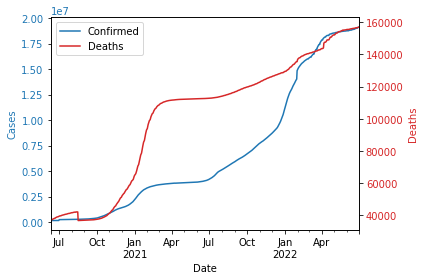

In [3]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('time (s)')
ax1.set_ylabel('Cases', color=color)
plot1 = df.plot.line('Date', 'Confirmed', ax=ax1, color=color, legend=False)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:red'
ax2.set_ylabel('Deaths', color=color)
plot2 = df.plot.line('Date', 'Deaths', ax=ax2, color=color, legend=False)
ax2.tick_params(axis='y', labelcolor=color)

lines = [plot.lines[0] for plot in [plot1, plot2]]
labels = [l.get_label() for l in lines]
plt.legend(lines, labels)
fig.tight_layout()
# plt.savefig(f"../images/data_trends/cumulative_data_{location}.png")

## Daily Data

Plot the daily reported cases and data, flagging inconsistencies in the data (when either cumulative value drops).

In [4]:
df["Daily_Deaths"] = df["Deaths"].diff()
df["Daily_Cases"] = df["Confirmed"].diff()

print(str((df["Daily_Deaths"] < 0).sum()) + " negative values in death record")
print(str((df["Daily_Cases"] < 0).sum()) + " negative values in cases record")

df[["Daily_Deaths","Daily_Cases"]] = df[["Daily_Deaths","Daily_Cases"]].clip(lower = 0)

3 negative values in death record
3 negative values in cases record


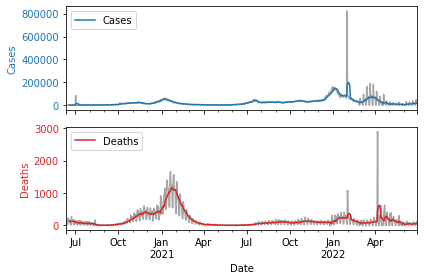

In [5]:
def plot_daily_panel(df, column, ax, color, label, weekly_ave = True):
    """Daily data in grey, with 7-day rolling average (gaussian window)"""
    ax.set_ylabel(label, color=color)
    plot = df.plot.line('Date', column, ax=ax, color='gray', label='', alpha=0.7)
    if weekly_ave:
        ax.plot(df['Date'], df[column].rolling(7, win_type='gaussian').mean(std=4),
                color=color, label=label)
    ax.tick_params(axis='y', labelcolor=color)
    ax.legend(loc=2)
    return plot
    
fig, axs = plt.subplots(2)

plot_daily_panel(df, 'Daily_Cases', ax=axs[0], color='tab:blue', label="Cases")
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

plot_daily_panel(df, 'Daily_Deaths', ax=axs[1], color='tab:red', label="Deaths")

fig.tight_layout()
# plt.savefig(f"../images/data_trends/daily_data_{location}.png")

## Fourier Spectra

We will consider any periodicity in Fourier space. For this it is helpful to normalise the data - we will do this by introducing a relative reporting factor (greek letter tbc) which defines the scaling between the reported value and the true value. For data where the true value is not known (such as in this case), we compare to a 7-day rolling average (uniform window).

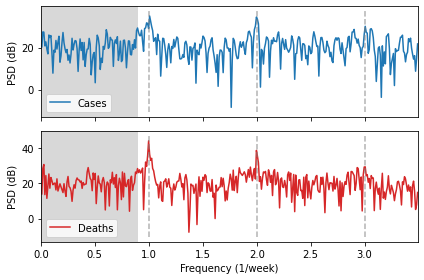

In [6]:
# Plot Fourier components of case data

df["Days"] = df["Date"].apply(lambda date: (date - min(df["Date"])).days)

def fourier_transform(df, column, compute_psd = False):
    data = df[column].fillna(0).values
    data_fft = sp.fftpack.fft(data)
    data_psd = np.abs(data_fft) ** 2  # Power Spectral density

    fftfreq = sp.fftpack.fftfreq(len(data_fft), 1/7)  # Frequency units in weeks
    return (data_psd, fftfreq) if compute_psd else (data_fft, fftfreq)

def plot_fft(data, freq, ax, color, label):
    i = freq > 0  # Remove negative frequencies
    ax.plot(freq[i], 10 * np.log10(data[i]), color=color, label=label)
    y_lim = ax.get_ylim()
    ax.vlines([(n+1) for n in range(3)], y_lim[0], y_lim[1],
              colors='gray', linestyles='dashed', alpha=0.6)
    ax.axvspan(0, 0.9, facecolor='gray', alpha=0.3)
    ax.set_xlabel('Frequency (1/week)')
    ax.set_ylabel('PSD (dB)')
    ax.legend(loc=3); ax.set_xlim((0, max(freq[i])))

fig, axs = plt.subplots(2)

df = rel_reporting_calc(df, ['Daily_Cases', 'Daily_Deaths'])

case_fft, case_freq = fourier_transform(df, column='Dif_Daily_Cases', compute_psd=True)
plot_fft(case_fft, case_freq, ax=axs[0], color='tab:blue', label="Cases")
axs[0].set_xlabel(''); axs[0].set_xticklabels([])

death_fft, death_freq = fourier_transform(df, column='Dif_Daily_Deaths', compute_psd=True)
plot_fft(death_fft, death_freq, ax=axs[1], color='tab:red', label="Deaths")

fig.tight_layout()
# plt.savefig(f"../images/data_trends/daily_fft_{location}_shaded.png")
# Shading used to match up with regions used in reconstruction


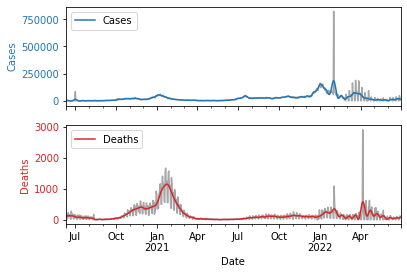

In [7]:
# Data with High freq components removed
def plot_ifft(df, column, ax, color, label, cutoff=None, window=None):
    data_fft, data_freq = fourier_transform(df, column=column, compute_psd=False)
    data_crop_fft = data_fft.copy()
    if cutoff is not None:
        data_crop_fft[np.abs(data_freq) > cutoff] = 0
    if window is not None:
        a = window / 2
        data_crop_fft[((np.abs(data_freq) > (1-a))) & (np.abs(data_freq) < (1+a))] = 0
        data_crop_fft[((np.abs(data_freq) > (2-a))) & (np.abs(data_freq) < (2+a))] = 0
    data_crop = np.real(sp.fftpack.ifft(data_crop_fft))
    
    df.plot.line('Date', column, color='gray', ax=ax, label='', alpha=0.7, legend=False)
    ax.plot(df['Date'], data_crop, color=color, label=label)
    ax.legend(loc=2); ax.set_ylabel(label, color=color)
    ax.tick_params(axis='y', labelcolor=color)

fig, axs = plt.subplots(2)
cutoff = 0.5

plot_ifft(df, 'Daily_Cases', cutoff=cutoff, ax=axs[0], color='tab:blue', label="Cases")
plot_ifft(df, 'Daily_Deaths', cutoff=cutoff, ax=axs[1], color='tab:red', label="Deaths")
axs[0].set_xlabel(''); axs[0].set_xticklabels([]);
# plt.savefig(f"../images/data_trends/daily_ifft_{location}_cutoff{cutoff}.png")


Cutting out all frequencies above $0.9 \; week^{-1}$ works well, but we still observe oscillations before a peak. This is related to the Gibbs phenomenan; sharp changes cannot be replicated exactly by a finite Fourier series. In this case, we only have low order terms, so have a region of oscillation to reach this sharp peak. These oscillations can only be removed with higher order terms.

We might consider cutting out frequencies $\nu$ in the window $(1-\alpha) < \nu < (1+\alpha) \; week^{-1}$ for small $\alpha$, or even extending this to all natural integers to account for higher harmonics/overtones. However, this would only work if the oscilations are sinousoidal - more complex oscillations are composed of multiple frequencies and so all of these would need to be removed. In an extreme case, a periodic square wave is comprised of many more frequencies than simply its base frequency, and so removing only the base frequency from the Fourier spectrum would not remove the periodicity in the data.

As all of these other frequency components contributing to the periodic pattern observed must necessarily be higher in frequency than the observed frequency of the repreating pattern, it is therefore necessary to exclude all frequency terms above the observed frequency.

## Weekly Patterns
We can identify periodic, weekly variation in the observed reporting factor.

In [8]:
summary = df.groupby('Weekday').median().sort_values('Day_Index')
print(summary[['Dif_Daily_Cases', 'Dif_Daily_Deaths']])

# Median is similar to mean, once extreme (>2) values are excluded.

           Dif_Daily_Cases  Dif_Daily_Deaths
Weekday                                     
Monday            0.970370          0.354420
Tuesday           0.985230          1.570285
Wednesday         1.053497          1.319828
Thursday          1.119201          1.148395
Friday            1.066007          1.119835
Saturday          0.974662          1.024560
Sunday            0.882779          0.398391


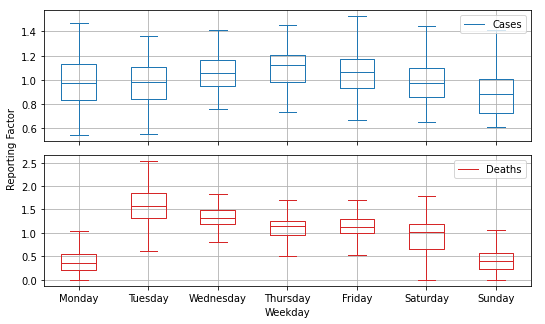

In [9]:
def rel_reporting_plot(daily_df, column, ax, color, label):
    daily_df = rel_reporting_calc(daily_df, [column])
    # daily_df['Dif_' + column].fillna(0, inplace=True)

    daily_df.boxplot(column=('Dif_' + column), by='Day_Index', # positions='DayIndex',
                     ax=ax, color=color, sym='')
    ax.set_xticks([1, 2, 3, 4, 5, 6, 7],
                  ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    ax.set_title(''); ax.legend(labels=[label], loc=1, framealpha=0.8)

fig, axs = plt.subplots(2, figsize=(8,5))
rel_reporting_plot(df.copy(), 'Daily_Cases',  ax=axs[0],
                   color='#1f77b4', label="Cases")  
                   # tab:blue not recognised here - this is the equivalent hexadecimal
rel_reporting_plot(df.copy(), 'Daily_Deaths',  ax=axs[1],
                   color='tab:red', label="Deaths")

axs[0].set_xlabel(''); axs[0].set_xticklabels([]); axs[1].set_xlabel('Weekday')

fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Reporting Factor")

plt.suptitle(''); plt.tight_layout()
# plt.savefig(f"../images/data_trends/daily_whisker_{location}.png")

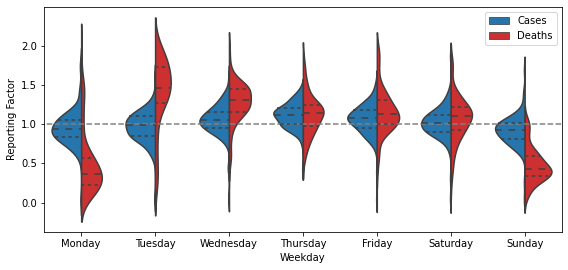

In [11]:
def rel_reporting_violin(daily_df, value_cols, ax, cutoff, colors, labels):
    for column in value_cols:
        daily_df = rel_reporting_calc(daily_df, [column])

    id_col = list(daily_df.columns.values)
    for i, value in enumerate(value_cols):
        value_cols[i] = 'Dif_' + value
        id_col.remove('Dif_' + value)
    violin_df = pd.melt(daily_df, id_vars = id_col, value_vars=value_cols, var_name='Type')
    ax.hlines(y=1, xmin=-1, xmax=7, linestyles="dashed", color="gray")

    #N.B exclude zero values from discrete nature of data - distorts violin
    sns.violinplot(data=violin_df, y=violin_df[(violin_df['value']<cutoff) & (violin_df['value']>0)]['value'],
                   ax=ax, x='Weekday', hue='Type', palette=colors, saturation=0.9, split=True, inner='quartile',# cut=0,
                   order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    ax.set_title(''); ax.set_xlim(-0.5,6.5)
    ax.legend(handles=ax.legend_.legendHandles, labels=labels)

fig, axs = plt.subplots(1, figsize=(8,4))
rel_reporting_violin(df.copy(), ['Daily_Cases', 'Daily_Deaths'],  ax=axs, cutoff=2,
                   colors=['tab:blue', 'tab:red'], labels=["Cases", "Deaths"])  

plt.xlabel('Weekday'); plt.ylabel("Reporting Factor")
plt.suptitle(''); plt.tight_layout()
# plt.savefig(f"../images/data_trends/daily_violin_{location}.png")

For deaths in particular, there is significant under-reporting on sundays and mondays. These seems like it could be a bug - originating from the American tendency to list Sunday (not Monday) as the first day of the week. However I have double-checked the indexing methods used and believe this is not a bug -  we can even see in `print(df)` that the final rows have the correct weekdays corresponding to the listed weekdays.

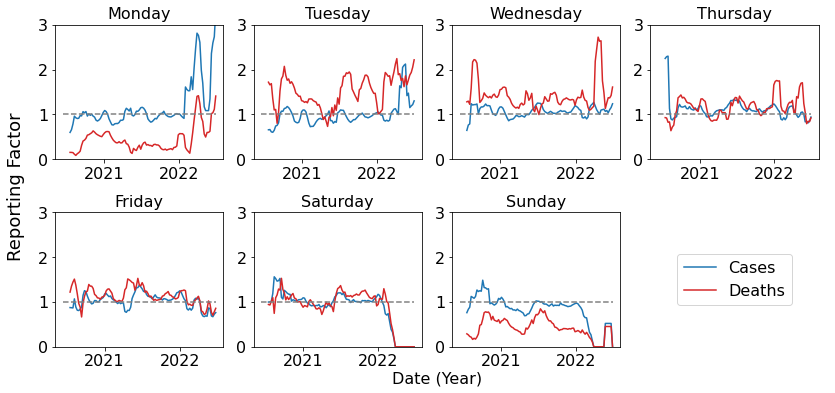

In [36]:
fig, axs = plt.subplots(2,4, figsize=(12,6))
axs[-1, -1].set_axis_off()
font_size = 16

for day in range(7):
    day_df = df[df['Day_Index'] == day]
    ax = axs.reshape(-1)[day]
    ax.plot(day_df['Date'], day_df['Dif_Daily_Cases'].rolling(5).mean(), color='tab:blue', label='Cases')
    ax.plot(day_df['Date'], day_df['Dif_Daily_Deaths'].rolling(5).mean(), color='tab:red', label='Deaths')
    ax.hlines(y=1, xmin=min(day_df['Date']), xmax=max(day_df['Date']), linestyles="dashed", color="gray")
    ax.set_title(day_df['Weekday'].iloc[0], fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.xaxis.set_major_locator(matplotlib.dates.YearLocator()); ax.set_ylim(0, 3)

ax2 = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Reporting Factor", fontsize=18); plt.xlabel('Date (Year)', fontsize=font_size)

handles, labels = axs.reshape(-1)[-2].get_legend_handles_labels()
axs.reshape(-1)[-1].legend(handles=handles, labels=labels, loc=10, fontsize=font_size)
plt.tight_layout()
# plt.savefig(f"../images/data_trends/daily_reporting_{location}.png")

## Reporting Bias

We need to be able to represent this reporting bias, to generate our own synthetic data. Does it scale with pandemic size, or is it relatively constant? We will focus on Saturday-Tuesday, as this is where the biggest deviations are observed. We may also separate the data into subsets before and after Feb 21st, as weekend reporting ceased after this date.

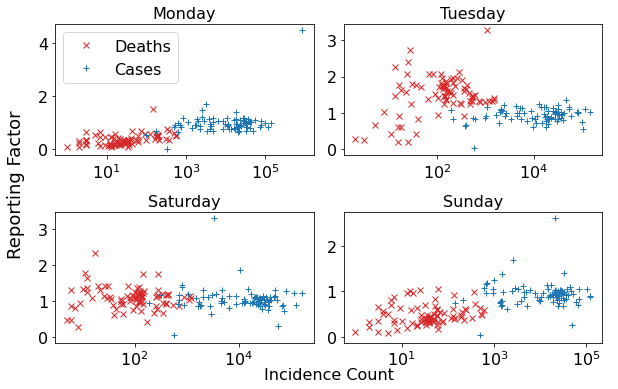

In [ ]:
day_indices = [0, 1, 5, 6]  # Only considering range Sat - Tues for visual simplicity
period_df = df[df['Date'] < '2022-02-21']  # Reporting changes on Feb 21st 2022

fig, axs = plt.subplots(2,2, figsize=(9,6))
font_size = 16

for i, day in enumerate(day_indices):
    day_df = period_df[period_df['Day_Index'] == day]
    ax = axs.reshape(-1)[i]
    ax.plot(day_df['Daily_Deaths'], day_df['Dif_Daily_Deaths'], color='tab:red',
            marker = 'x', linestyle = '', label = 'Deaths')
    ax.plot(day_df['Daily_Cases'], day_df['Dif_Daily_Cases'], color='tab:blue',
            marker = '+', linestyle = '', label = 'Cases')
    ax.set_title(day_df['Weekday'].iloc[0], fontsize=font_size)
    ax.tick_params(axis='both', which='major', labelsize=font_size)
    ax.set_xscale('log')

ax2 = fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.ylabel("Reporting Factor", fontsize=18); plt.xlabel('Incidence Count', fontsize=font_size)

axs[0,0].legend(loc=2, fontsize=font_size)
plt.tight_layout()
# plt.savefig(f"../images/data_trends/reporting_trends_{location}.png")

There is little correlation on Saturday (and more generally with the case data), however there seems to be a moderate correlation between reporting factor and death count. This is actually positive - i.e. reporting is better (i.e. closer to unity for Sunday/Monday) when there are more deaths, which might not have been expected.

In [69]:
day_indices = [0, 1, 5, 6]  # Only considering range Sat - Tues for visual simplicity
data_type = 'Deaths'

def print_lr(result):
    """Improved readability of linear regression results"""
    print(f"{day_df['Weekday'].iloc[0]}: Best fit line: {result.slope:.2g} N " +
          f"+ {result.intercept:.2g}; R^2 = {result.rvalue:.2f}")

for i, day in enumerate(day_indices):
    day_df = period_df[period_df['Day_Index'] == day]
    result = sp.stats.linregress(day_df['Daily_' + data_type][1:], day_df['Dif_Daily_' + data_type][1:])
    print_lr(result)

Monday: Best fit line: 0.00081 N + 0.29; R^2 = 0.44
Tuesday: Best fit line: 0.00024 N + 1.4; R^2 = 0.14
Saturday: Best fit line: 1.1e-05 N + 1.1; R^2 = 0.01
Sunday: Best fit line: 0.00037 N + 0.44; R^2 = 0.21
